In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=100 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [27]:
y.shape

(144, 2)

In [28]:
x_para_train, x_para_test, x_train, x_test, y_train, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [29]:
x_train.shape

(100, 2, 55, 1)

In [30]:
y_train.shape

(100, 2)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 100)   500         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 100)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2700)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 3s 5ms/step - loss: 0.7023 - rmse: 0.8380 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.3353 - rmse: 0.5791 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.1806 - rmse: 0.4250 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.1310 - rmse: 0.3619 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.1385 - rmse: 0.3721 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.1128 - rmse: 0.3359 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.1157 - rmse: 0.3401 - lr: 0.0010
Epoch 8/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.1096 - rmse: 0.3311 - lr: 0.0010
Epoch 9/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.1063 - rmse: 0.3261 - lr: 0.0010
Epoch 10/5000
5/5 [==================

Epoch 77/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0165 - rmse: 0.1284 - lr: 0.0010
Epoch 78/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0155 - rmse: 0.1247 - lr: 0.0010
Epoch 79/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - rmse: 0.1250 - lr: 0.0010
Epoch 80/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0157 - rmse: 0.1252 - lr: 0.0010
Epoch 81/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0150 - rmse: 0.1224 - lr: 0.0010
Epoch 82/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0151 - rmse: 0.1228 - lr: 0.0010
Epoch 83/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0148 - rmse: 0.1218 - lr: 0.0010
Epoch 84/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0152 - rmse: 0.1234 - lr: 0.0010
Epoch 85/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0171 - rmse: 0.1308 - lr: 0.0010
Epoch 86/5000
5/5 [=========

5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1075 - lr: 0.0010
Epoch 153/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0130 - rmse: 0.1142 - lr: 0.0010
Epoch 154/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0091 - rmse: 0.0955 - lr: 0.0010
Epoch 155/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0079 - rmse: 0.0890 - lr: 0.0010
Epoch 156/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0068 - rmse: 0.0826 - lr: 0.0010
Epoch 157/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0080 - rmse: 0.0895 - lr: 0.0010
Epoch 158/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0095 - rmse: 0.0976 - lr: 0.0010
Epoch 159/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0094 - rmse: 0.0972 - lr: 0.0010
Epoch 160/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0083 - rmse: 0.0913 - lr: 0.0010
Epoch 161/5000
5/5 [==============

5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0514 - lr: 0.0010
Epoch 228/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0433 - lr: 0.0010
Epoch 229/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0466 - lr: 0.0010
Epoch 230/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0471 - lr: 0.0010
Epoch 231/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0410 - lr: 0.0010
Epoch 232/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0317 - lr: 0.0010
Epoch 233/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.3347e-04 - rmse: 0.0289 - lr: 0.0010
Epoch 234/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0390 - lr: 0.0010
Epoch 235/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - rmse: 0.0461 - lr: 0.0010
Epoch 236/5000
5/5 [==========

5/5 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0409 - lr: 0.0010
Epoch 302/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0505 - lr: 0.0010
Epoch 303/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0457 - lr: 0.0010
Epoch 304/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0351 - lr: 0.0010
Epoch 305/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.8057e-04 - rmse: 0.0279 - lr: 0.0010
Epoch 306/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0014 - rmse: 0.0376 - lr: 0.0010
Epoch 307/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0341 - lr: 0.0010
Epoch 308/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.8010e-04 - rmse: 0.0261 - lr: 0.0010
Epoch 309/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.3656e-04 - rmse: 0.0271 - lr: 0.0010
Epoch 310/5000
5/5 [==

Epoch 374/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.1916e-04 - rmse: 0.0205 - lr: 0.0010
Epoch 375/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.1560e-04 - rmse: 0.0204 - lr: 0.0010
Epoch 376/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.6415e-04 - rmse: 0.0191 - lr: 0.0010
Epoch 377/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.9980e-04 - rmse: 0.0224 - lr: 0.0010
Epoch 378/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.8305e-04 - rmse: 0.0297 - lr: 0.0010
Epoch 379/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0013 - rmse: 0.0365 - lr: 0.0010
Epoch 380/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0396 - lr: 0.0010
Epoch 381/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0398 - lr: 0.0010
Epoch 382/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0436 - lr: 0.0010

Epoch 447/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.9382e-04 - rmse: 0.0222 - lr: 0.0010
Epoch 448/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.4761e-04 - rmse: 0.0254 - lr: 0.0010
Epoch 449/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.9568e-04 - rmse: 0.0244 - lr: 0.0010
Epoch 450/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.7049e-04 - rmse: 0.0295 - lr: 0.0010
Epoch 451/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0351 - lr: 0.0010
Epoch 452/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.3314e-04 - rmse: 0.0289 - lr: 0.0010
Epoch 453/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.3812e-04 - rmse: 0.0209 - lr: 0.0010
Epoch 454/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.0929e-04 - rmse: 0.0202 - lr: 0.0010
Epoch 455/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.7325e-04 - rmse: 0.0218 

5/5 [==============================] - 0s 6ms/step - loss: 1.6648e-04 - rmse: 0.0129 - lr: 0.0010
Epoch 520/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.3903e-04 - rmse: 0.0118 - lr: 0.0010
Epoch 521/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.4679e-05 - rmse: 0.0097 - lr: 0.0010
Epoch 522/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.3112e-04 - rmse: 0.0115 - lr: 0.0010
Epoch 523/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.7649e-04 - rmse: 0.0133 - lr: 0.0010
Epoch 524/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.4414e-04 - rmse: 0.0120 - lr: 0.0010
Epoch 525/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.3425e-04 - rmse: 0.0116 - lr: 0.0010
Epoch 526/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1641e-04 - rmse: 0.0108 - lr: 0.0010
Epoch 527/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.4074e-04 - rmse: 0.0119 - lr: 0.001

5/5 [==============================] - 0s 6ms/step - loss: 1.4772e-04 - rmse: 0.0122 - lr: 0.0010
Epoch 592/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.0521e-04 - rmse: 0.0103 - lr: 0.0010
Epoch 593/5000
5/5 [==============================] - 0s 7ms/step - loss: 9.3841e-05 - rmse: 0.0097 - lr: 0.0010
Epoch 594/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.0032e-05 - rmse: 0.0084 - lr: 0.0010
Epoch 595/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.4948e-05 - rmse: 0.0092 - lr: 0.0010
Epoch 596/5000
5/5 [==============================] - 0s 7ms/step - loss: 9.2297e-05 - rmse: 0.0096 - lr: 0.0010
Epoch 597/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.3156e-04 - rmse: 0.0115 - lr: 0.0010
Epoch 598/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1086e-04 - rmse: 0.0105 - lr: 0.0010
Epoch 599/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.6391e-04 - rmse: 0.0128 - lr: 0.001

5/5 [==============================] - 0s 7ms/step - loss: 0.0072 - rmse: 0.0846 - lr: 0.0010
Epoch 665/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0039 - rmse: 0.0623 - lr: 0.0010
Epoch 666/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - rmse: 0.0487 - lr: 0.0010
Epoch 667/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0436 - lr: 0.0010
Epoch 668/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0600 - lr: 0.0010
Epoch 669/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0037 - rmse: 0.0608 - lr: 0.0010
Epoch 670/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0490 - lr: 0.0010
Epoch 671/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0013 - rmse: 0.0354 - lr: 0.0010
Epoch 672/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.7177e-04 - rmse: 0.0295 - lr: 0.0010
Epoch 673/5000
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 3.8771e-05 - rmse: 0.0062 - lr: 5.0000e-04
Epoch 735/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.8089e-05 - rmse: 0.0062 - lr: 5.0000e-04
Epoch 736/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.1126e-05 - rmse: 0.0064 - lr: 5.0000e-04
Epoch 737/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.7196e-05 - rmse: 0.0061 - lr: 5.0000e-04
Epoch 738/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.5987e-05 - rmse: 0.0060 - lr: 5.0000e-04
Epoch 739/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.8258e-05 - rmse: 0.0062 - lr: 5.0000e-04
Epoch 740/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.8093e-05 - rmse: 0.0062 - lr: 5.0000e-04
Epoch 741/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.7213e-05 - rmse: 0.0061 - lr: 5.0000e-04
Epoch 742/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.140

5/5 [==============================] - 0s 6ms/step - loss: 3.3913e-05 - rmse: 0.0058 - lr: 5.0000e-04
Epoch 805/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.3313e-05 - rmse: 0.0058 - lr: 5.0000e-04
Epoch 806/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.2034e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 807/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.9060e-05 - rmse: 0.0054 - lr: 5.0000e-04
Epoch 808/5000
5/5 [==============================] - 0s 7ms/step - loss: 2.6901e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 809/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.0055e-05 - rmse: 0.0055 - lr: 5.0000e-04
Epoch 810/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.9167e-05 - rmse: 0.0054 - lr: 5.0000e-04
Epoch 811/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.7397e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 812/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.730

5/5 [==============================] - 0s 6ms/step - loss: 2.8242e-05 - rmse: 0.0053 - lr: 5.0000e-04
Epoch 875/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.5106e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 876/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.6219e-05 - rmse: 0.0051 - lr: 5.0000e-04
Epoch 877/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.6904e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 878/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.2786e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 879/5000
5/5 [==============================] - 0s 7ms/step - loss: 2.0982e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 880/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.1763e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 881/5000
5/5 [==============================] - 0s 7ms/step - loss: 2.5054e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 882/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.761

5/5 [==============================] - 0s 6ms/step - loss: 2.7077e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 945/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.1013e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 946/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.9234e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 947/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.8719e-05 - rmse: 0.0043 - lr: 5.0000e-04
Epoch 948/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.4063e-05 - rmse: 0.0049 - lr: 5.0000e-04
Epoch 949/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.3758e-05 - rmse: 0.0049 - lr: 5.0000e-04
Epoch 950/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.4697e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 951/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.2823e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 952/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.703

5/5 [==============================] - 0s 7ms/step - loss: 1.8282e-05 - rmse: 0.0043 - lr: 5.0000e-04
Epoch 1015/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.6812e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 1016/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.6568e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 1017/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.4205e-05 - rmse: 0.0038 - lr: 5.0000e-04
Epoch 1018/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.5534e-05 - rmse: 0.0039 - lr: 5.0000e-04
Epoch 1019/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.7805e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 1020/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.9622e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 1021/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.2964e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 1022/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 5.7841e-05 - rmse: 0.0076 - lr: 5.0000e-04
Epoch 1084/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.7489e-05 - rmse: 0.0076 - lr: 5.0000e-04
Epoch 1085/5000
5/5 [==============================] - 0s 6ms/step - loss: 7.7558e-05 - rmse: 0.0088 - lr: 5.0000e-04
Epoch 1086/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.0152e-05 - rmse: 0.0084 - lr: 5.0000e-04
Epoch 1087/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.7797e-05 - rmse: 0.0061 - lr: 5.0000e-04
Epoch 1088/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.8272e-05 - rmse: 0.0053 - lr: 5.0000e-04
Epoch 1089/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.9745e-05 - rmse: 0.0055 - lr: 5.0000e-04
Epoch 1090/5000
5/5 [==============================] - 0s 6ms/step - loss: 2.9660e-05 - rmse: 0.0054 - lr: 5.0000e-04
Epoch 1091/5000
5/5 [==============================] - 0s 7ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 1.2601e-05 - rmse: 0.0035 - lr: 2.5000e-04
Epoch 1152/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1773e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 1153/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.3549e-05 - rmse: 0.0037 - lr: 2.5000e-04
Epoch 1154/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.0401e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1155/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.1028e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1156/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1422e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 1157/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1345e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 1158/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.0727e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1159/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 8.8503e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 1221/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.9675e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 1222/5000
5/5 [==============================] - 0s 6ms/step - loss: 9.6295e-06 - rmse: 0.0031 - lr: 2.5000e-04
Epoch 1223/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.2648e-05 - rmse: 0.0036 - lr: 2.5000e-04
Epoch 1224/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.2608e-05 - rmse: 0.0036 - lr: 2.5000e-04
Epoch 1225/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.0577e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1226/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1160e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1227/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.2552e-05 - rmse: 0.0035 - lr: 2.5000e-04
Epoch 1228/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 1.1687e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 1290/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.0894e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1291/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1832e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 1292/5000
5/5 [==============================] - 0s 6ms/step - loss: 9.5176e-06 - rmse: 0.0031 - lr: 2.5000e-04
Epoch 1293/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.3130e-05 - rmse: 0.0036 - lr: 2.5000e-04
Epoch 1294/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1946e-05 - rmse: 0.0035 - lr: 2.5000e-04
Epoch 1295/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.0253e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1296/5000
5/5 [==============================] - 0s 6ms/step - loss: 9.4155e-06 - rmse: 0.0031 - lr: 2.5000e-04
Epoch 1297/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 1.5053e-05 - rmse: 0.0039 - lr: 2.5000e-04
Epoch 1359/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1948e-05 - rmse: 0.0035 - lr: 2.5000e-04
Epoch 1360/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.0361e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1361/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.1115e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1362/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.3592e-05 - rmse: 0.0037 - lr: 2.5000e-04
Epoch 1363/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.9482e-05 - rmse: 0.0044 - lr: 2.5000e-04
Epoch 1364/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.7253e-05 - rmse: 0.0061 - lr: 2.5000e-04
Epoch 1365/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.4342e-05 - rmse: 0.0067 - lr: 2.5000e-04
Epoch 1366/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 9.7540e-06 - rmse: 0.0031 - lr: 1.2500e-04
Epoch 1427/5000
5/5 [==============================] - 0s 6ms/step - loss: 9.7092e-06 - rmse: 0.0031 - lr: 1.2500e-04
Epoch 1428/5000
5/5 [==============================] - 0s 6ms/step - loss: 7.3759e-06 - rmse: 0.0027 - lr: 1.2500e-04
Epoch 1429/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.5715e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1430/5000
5/5 [==============================] - 0s 6ms/step - loss: 7.1873e-06 - rmse: 0.0027 - lr: 1.2500e-04
Epoch 1431/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.4109e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1432/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.2017e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1433/5000
5/5 [==============================] - 0s 6ms/step - loss: 7.0262e-06 - rmse: 0.0027 - lr: 1.2500e-04
Epoch 1434/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 6.2006e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1496/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.7961e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1497/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.2878e-06 - rmse: 0.0029 - lr: 1.2500e-04
Epoch 1498/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.5419e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1499/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.1873e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1500/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.1712e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1501/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.7799e-06 - rmse: 0.0024 - lr: 1.2500e-04
Epoch 1502/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.8412e-06 - rmse: 0.0024 - lr: 1.2500e-04
Epoch 1503/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 5.7196e-06 - rmse: 0.0024 - lr: 1.2500e-04
Epoch 1565/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.5990e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1566/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.7955e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1567/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.3165e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1568/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.1745e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1569/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.4987e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1570/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.2767e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1571/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.5175e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1572/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 6.5796e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1634/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.8703e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1635/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.1346e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1636/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.0039e-06 - rmse: 0.0028 - lr: 1.2500e-04
Epoch 1637/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.8909e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1638/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.5392e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1639/5000
5/5 [==============================] - 0s 6ms/step - loss: 9.2754e-06 - rmse: 0.0030 - lr: 1.2500e-04
Epoch 1640/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.1834e-05 - rmse: 0.0034 - lr: 1.2500e-04
Epoch 1641/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 4.6739e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1702/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.7220e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1703/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.0518e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1704/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.5000e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1705/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.0898e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1706/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.2106e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1707/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.9568e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1708/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.1003e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1709/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 5.3045e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1771/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.0789e-06 - rmse: 0.0025 - lr: 6.2500e-05
Epoch 1772/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.2399e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1773/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.7211e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1774/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.7601e-06 - rmse: 0.0024 - lr: 6.2500e-05
Epoch 1775/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.9224e-06 - rmse: 0.0024 - lr: 6.2500e-05
Epoch 1776/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.7055e-06 - rmse: 0.0024 - lr: 6.2500e-05
Epoch 1777/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.2040e-06 - rmse: 0.0023 - lr: 6.2500e-05
Epoch 1778/5000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 4.8693e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1840/5000
5/5 [==============================] - 0s 7ms/step - loss: 4.7252e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1841/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.7514e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1842/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.4609e-06 - rmse: 0.0025 - lr: 6.2500e-05
Epoch 1843/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.6541e-06 - rmse: 0.0024 - lr: 6.2500e-05
Epoch 1844/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.7480e-06 - rmse: 0.0026 - lr: 6.2500e-05
Epoch 1845/5000
5/5 [==============================] - 0s 6ms/step - loss: 5.0098e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1846/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.9491e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1847/5000
5/5 [==============================] - 0s 7ms/step - los

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:01:04.241144


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_I_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

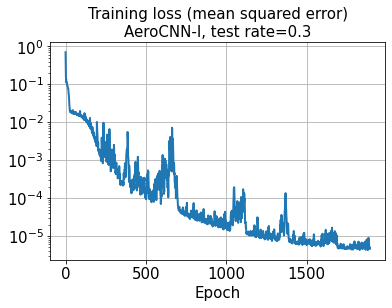

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

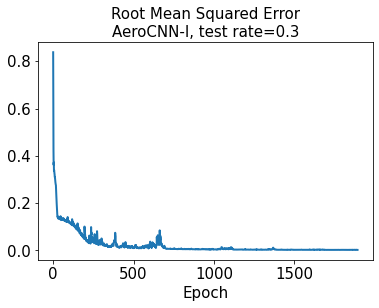

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-I, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

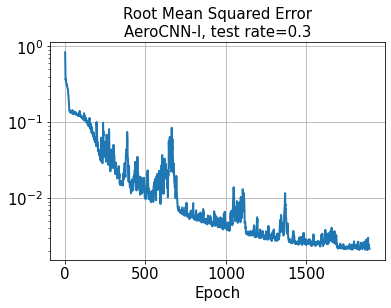

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-I, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 15ms/step - loss: 4.8657e-06 - rmse: 0.0022


In [44]:
test_results = model.evaluate([x_test, x_para_test], y_test)

2/2 [==============================] - 0s 44ms/step - loss: 2.1658e-04 - rmse: 0.0147


In [45]:
decoded_train = model.predict([x_train, x_para_train])
decoded_test = model.predict([x_test, x_para_test])

2/2 [==============================] - 0s 2ms/step


In [46]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_I_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = np.abs(decoded_train - y_train)

In [48]:
error_test_abs = np.abs(decoded_test - y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0024997180656904975


In [51]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.01862098915435186


In [52]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.02917490533445455


In [53]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.002249553590521545


In [54]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.04037054915133273


In [55]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.018583197372633063


In [56]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [58]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [59]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [60]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [61]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

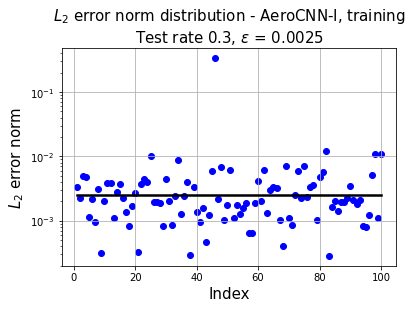

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

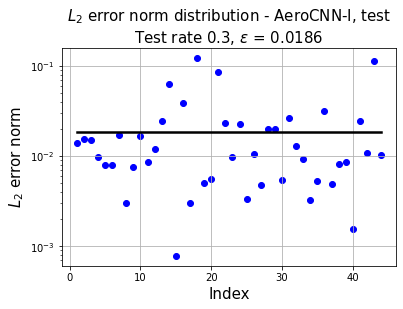

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

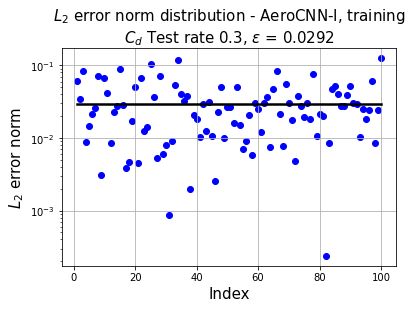

In [64]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

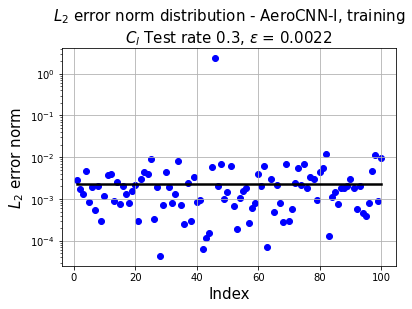

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

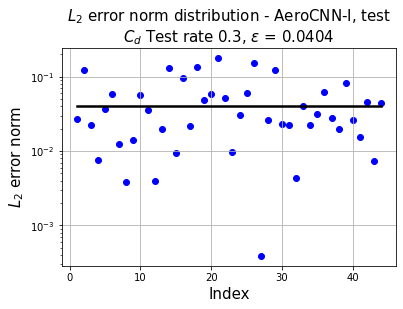

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

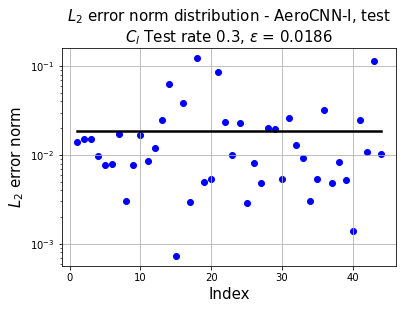

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()